In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
#added inspect to code
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite (address was incorrect in instructions)
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model 
Base = automap_base()

# reflect the tables (similar to SQL INS_Joins))
Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Get a list of columns and types
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Precipitation Analysis

In [30]:
#guide for queries
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'],c["type"])
print("------------------------------------")
columns2 = inspector.get_columns('station')
for c in columns2:
    print(c['name'],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
# https://stackoverflow.com/questions/8551952/how-to-get-last-record
rec_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(rec_date)

('2017-08-23',)


In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
print(rec_date)
# Calculate the date one year from the last date in data set.
#date is saved as text/string. Need to convert
#https://stackabuse.com/converting-strings-to-datetime-in-python/
#only want first entry (second is empty)
rec_date_dt = dt.datetime.strptime(rec_date[0], "%Y-%m-%d")
print(rec_date_dt)
one_year_dt = (rec_date_dt - dt.timedelta(days=365)).strftime("%Y-%m-%d")
print(one_year_dt)
#change to date
# Perform a query to retrieve the data and precipitation scores
#need .date and .precip
datePrecip = (Measurement.date, Measurement.prcp)
precipitation_scores = session.query(*datePrecip).filter(Measurement.date>= one_year_dt).all()
#print(precipitation_scores)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df=pd.DataFrame(precipitation_scores, columns=["Date", "Precipitation"])
precip_df.head()

# Sort the dataframe by date
precip_df.set_index("Date", inplace=True)
precip_df = precip_df.sort_index()





('2017-08-23',)
2017-08-23 00:00:00
2016-08-23


Text(0, 0.5, 'Precipitation Level (in)')

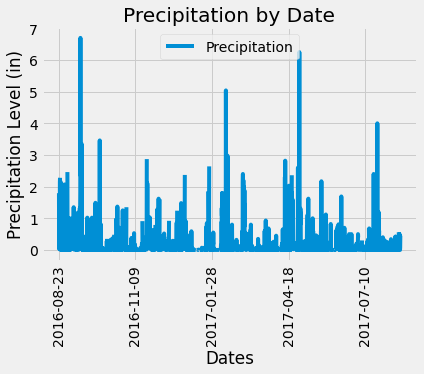

In [28]:

# Use Pandas Plotting with Matplotlib to plot the data
precip_plot = precip_df.plot(rot='90')
precip_plot.set_title("Precipitation by Date")
precip_plot.set_xlabel("Dates")
precip_plot.set_ylabel("Precipitation Level (in)")

In [29]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number stations in the dataset
station_number = session.query(func.count(Station.id)).all()
print(station_number)

[(9,)]


In [40]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
#List
list_station=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
list_station
                           


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [44]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
av_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
print(f"High Temp: {high_temp}")
print(f"Low Temp: {low_temp}")
print(f"Average Temp: {av_temp}")

High Temp: [(85.0,)]
Low Temp: [(54.0,)]
Average Temp: [(71.66378066378067,)]


Text(0.5, 0, 'Temperature Observed (F)')

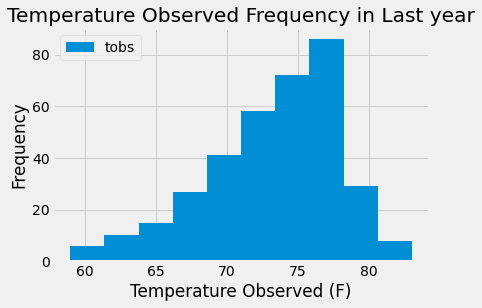

In [51]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
act_station_ob  =session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_dt).filter(Measurement.station =='USC00519281').all()
act_station_ob

aso_df = pd.DataFrame(act_station_ob)
aso_plot = aso_df.plot(kind="hist")
aso_plot.set_title("Temperature Observed Frequency in Last year")
aso_plot.set_xlabel("Temperature Observed (F)")


# Close session

In [52]:
# Close Session
session.close()